# OOI Lab Manual: Lab 8 Anoxic Events

This notebook demonstrates how to access and process the dataset used in *Lab 8 Anoxic Events* of the [2021 OOI Lab Manual](https://datalab.marine.rutgers.edu/ooi-lab-exercises/).

It is based on an [earlier notebook](https://github.com/ooi-data-lab/data-lab-workshops/blob/master/March2019/Activities/DL_March_Anoxia_v4.ipynb) created as part of the 2019 OOI Data Lab workshop series.

By Sage Lichtenwalner, Revised June 9, 2021

In [1]:
# Notebook Setup
import xarray as xr
import matplotlib.pyplot as plt

# # Setup default plot styles
# import seaborn as sns
# sns.set()

# Supress open_mfdataset warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install git+https://github.com/seagrinch/ooilab.git
import ooilab

In [3]:
ooilab.API_USERNAME = ''
ooilab.API_TOKEN = ''

## Request Data from OOINet

* **Wind data**: Oregon Shelf Surface Mooring, Surface Buoy, Bulk Meteorological Instrument Package (CE02SHSM-SBD11-06-METBKA000) recovered_host
* **Dissolved oxygen**: Oregon Inshore Surface Mooring, Seafloor Multi-function Mode (MFN), Dissolved Oxygen (CE01ISSM-MFD37-03-DOSTAD000) recovered_inst
* **Temperature**: Oregon Inshore Surface Mooring, Seafloor Multi-function Mode (MFN), (CE01ISSM-MFD37-03-CTDBPC000) recovered_inst
* Dissolved oxygen profile from shelf edge/slope station, if possible

In [4]:
# # Met Data
# ooilab.request_data('CE02SHSM-SBD11-06-METBKA000','recovered_host','metbk_a_dcl_instrument_recovered',
#              '2017-05-25T00:00:00.000Z','2017-06-25T00:00:00.000Z')
# # DO Data
# ooilab.request_data('CE01ISSM-MFD37-03-DOSTAD000','recovered_inst','dosta_abcdjm_ctdbp_instrument_recovered',
#              '2017-05-25T00:00:00.000Z','2017-06-25T00:00:00.000Z')
# # Temperature Data
# ooilab.request_data('CE01ISSM-MFD37-03-CTDBPC000','recovered_inst','ctdbp_cdef_instrument_recovered',
#              '2017-05-25T00:00:00.000Z','2017-06-25T00:00:00.000Z')
# # Glider Data
# ooilab.request_data('CE05MOAS-GL384-04-DOSTAM000','recovered_host','dosta_abcdjm_glider_recovered',
#              '2017-05-24T15:00:00.000Z','2017-05-27T00:00:00.000Z')  #Full transect goes to 2017-06-03T04:00:00.000Z

In [5]:
# Resultant Dataset Directories
url_met = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20210607T193305147Z-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
url_do = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20210607T193319725Z-CE01ISSM-MFD37-03-DOSTAD000-recovered_inst-dosta_abcdjm_ctdbp_instrument_recovered/catalog.html'
url_ctd = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20210607T193337703Z-CE01ISSM-MFD37-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'

# Full Transect
# url_gl384 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20210607T194723194Z-CE05MOAS-GL384-04-DOSTAM000-recovered_host-dosta_abcdjm_glider_recovered/catalog.html'
# Just the Shelf
url_gl384 = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/sage@marine.rutgers.edu/20210608T202230357Z-CE05MOAS-GL384-04-DOSTAM000-recovered_host-dosta_abcdjm_glider_recovered/catalog.html'


## Oregon Met & DO Data

In [6]:
# Load the datasets
data_met = xr.open_mfdataset(ooilab.get_filelist(url_met)).swap_dims({'obs': 'time'}).sortby('time')
data_do = xr.open_mfdataset(ooilab.get_filelist(url_do)).swap_dims({'obs': 'time'}).sortby('time')
data_ctd = xr.open_mfdataset(ooilab.get_filelist(url_ctd)).swap_dims({'obs': 'time'}).sortby('time')

In [7]:
# Convert DO from micromole/kg to mg/L
# Reference https://ocean.ices.dk/Tools/UnitConversion.aspx
# See also https://wiki.pangaea.de/wiki/Conversion

data_do['do'] = data_do.dissolved_oxygen * 1.025 / (44.661*0.7)
data_do['do'].attrs['long_name'] = 'DO'
data_do['do'].attrs['units'] = 'mg/L'

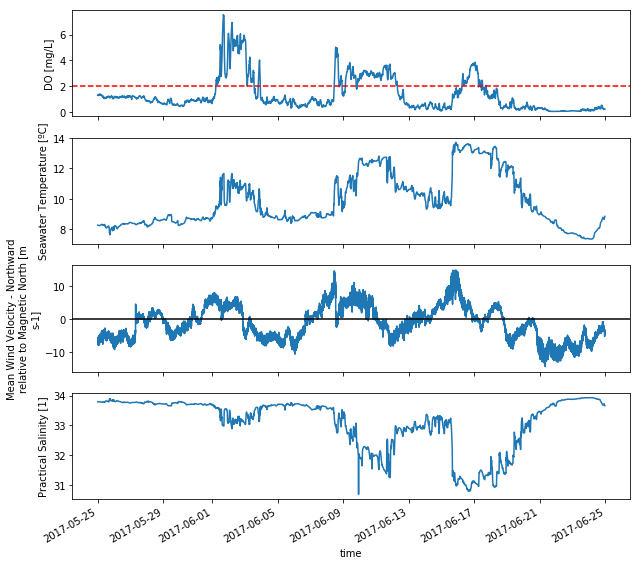

In [8]:
# Plot the data
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))
# data_do.dissolved_oxygen.plot(ax=ax1) # Original DO
data_do.do.plot(ax=ax1) # Converted DO
data_ctd.ctdbp_seawater_temperature.plot(ax=ax2)
data_met.northward_wind_velocity.plot(ax=ax3)
data_ctd.practical_salinity.plot(ax=ax4);

# Add line at 2mg/L for DO
xlim = ax1.get_xlim()
ax1.plot([xlim[0],xlim[1]],[2,2],'r--')

# Add 0 line for Wind
ax3.plot([xlim[0],xlim[1]],[0,0],'k')
ax3.set_xlim(xlim);

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('');

plt.savefig("anoxia_june2017.png");

## Merge and export

In [9]:
# Resample/average to 15 minutes
avgint = '1h' #'15min'
# a = data_do['dissolved_oxygen'].load().resample(time=avgint).mean()
a = data_do['do'].load().resample(time=avgint).mean()
b = data_ctd['ctdbp_seawater_temperature'].load().resample(time=avgint).mean()
c = data_met['northward_wind_velocity'].load().resample(time=avgint).mean()
d = data_ctd['practical_salinity'].load().resample(time=avgint).mean()

In [10]:
# Merge the datasets
x = xr.merge([a,b,c,d]).to_dataframe()

# Print the first few rows
x.head()

,do,ctdbp_seawater_temperature,northward_wind_velocity,practical_salinity
time,,,,
2017-05-25 00:00:00,1.288670,8.264365,-6.759833,33.786660
2017-05-25 01:00:00,1.322982,8.246202,-6.364333,33.791832
2017-05-25 02:00:00,1.345129,8.238258,-6.194167,33.793758
2017-05-25 03:00:00,1.321975,8.260391,-5.834000,33.789965
2017-05-25 04:00:00,1.326255,8.286342,-5.266667,33.784464


In [11]:
# Export to CSV
x.to_csv('anoxia2017.csv')

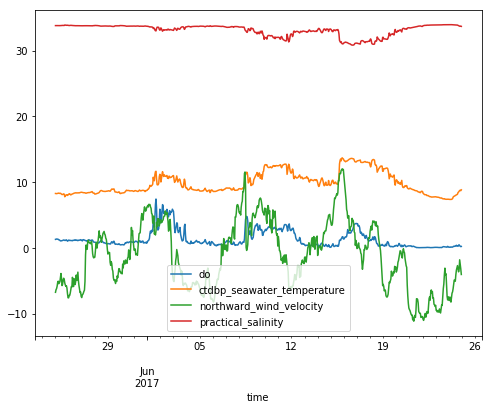

In [12]:
# Quicklook plot
x.plot(figsize=(8,6));

## Glider Transect

In [13]:
# Load data
data_gl384 = xr.open_mfdataset(ooilab.get_filelist(url_gl384)).swap_dims({'obs': 'time'}).sortby('time')

In [14]:
data_gl384 = data_gl384.to_dataframe()

In [15]:
# Convert DO from micromole/L to mg/L (this is different than above)
# Reference https://wiki.pangaea.de/wiki/Conversion
data_gl384['do'] = data_gl384.sci_oxy4_oxygen / (44.661*0.7)

In [16]:
# Remove glider surfacing points
data_gl384 = data_gl384[data_gl384.int_ctd_pressure > 1]

In [17]:
# Drop nans
data_gl384 = data_gl384.dropna(subset=['lat'])

In [18]:
# Calculate distance from CE01ISSM
import geopy.distance
data_gl384['distance'] = data_gl384.apply(lambda row: geopy.distance.distance((44.66,-124.095),(row['lat'],row['lon'])).km, axis=1)

### Raw Dots

In [19]:
# !pip install cmocean
import cmocean
import pandas as pd

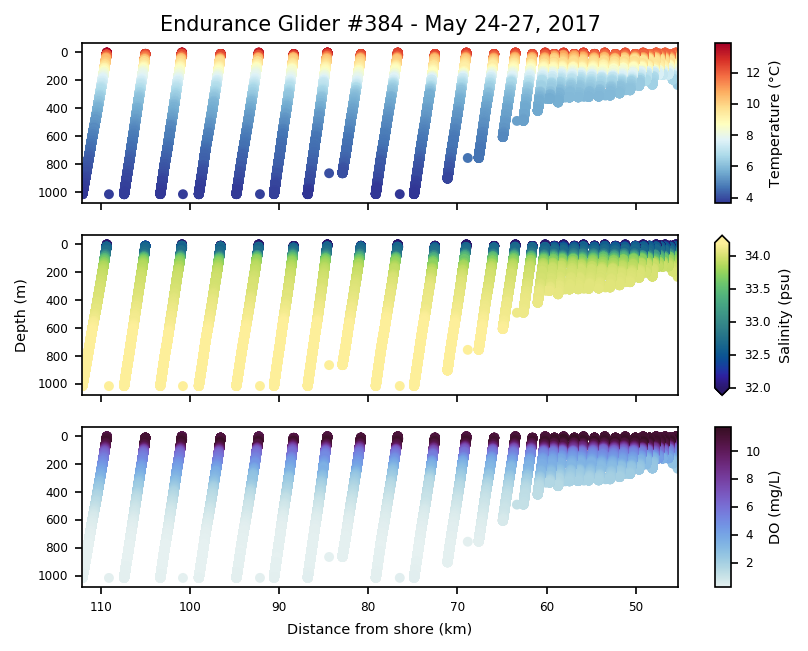

In [20]:
# Plot the data - Distance on x-axis
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True, sharey=True)
fig.set_size_inches(6.4,4.8)
# fig.set_size_inches(8,8)
fig.set_dpi(150)

ms = 56 #marker size
a1 = ax1.scatter(data_gl384.distance, data_gl384.int_ctd_pressure, c=data_gl384.sci_water_temp, marker=".", s=ms, cmap='RdYlBu_r')
a2 = ax2.scatter(data_gl384.distance, data_gl384.int_ctd_pressure, c=data_gl384.practical_salinity, marker=".", s=ms, cmap=cmocean.cm.haline, vmin=32, vmax=34.2)
a3 = ax3.scatter(data_gl384.distance, data_gl384.int_ctd_pressure, c=data_gl384.do, marker=".", s=ms, cmap=cmocean.cm.dense) #vmin=0, vmax=300

cb1 = plt.colorbar(a1,ax=ax1, aspect=10)
cb2 = plt.colorbar(a2,ax=ax2,extend='both', aspect=10)
cb3 = plt.colorbar(a3,ax=ax3, aspect=10)
cb1.set_label('Temperature (°C)',fontsize='x-small')
cb2.set_label('Salinity (psu)',fontsize='x-small')
cb3.set_label('DO (mg/L)',fontsize='x-small')

ax2.set_ylabel("Depth (m)",fontsize='x-small')
ax1.invert_yaxis()

# ax3.set_xlabel('Distance from CE01ISSM (in km)',fontsize='x-small')
ax3.set_xlabel('Distance from shore (km)',fontsize='x-small')
ax1.set_xlim(min(data_gl384.distance),max(data_gl384.distance));
ax1.invert_xaxis()

ax1.set_title('Endurance Glider #384 - May 24-27, 2017', fontsize='medium')

ax1.tick_params(labelsize='xx-small')
ax2.tick_params(labelsize='xx-small')
ax3.tick_params(labelsize='xx-small')
cb1.ax.tick_params(labelsize='xx-small')
cb2.ax.tick_params(labelsize='xx-small')
cb3.ax.tick_params(labelsize='xx-small')

plt.savefig("glider384_transect1.png")

### Interpolated (w and w/o dots)

In [21]:
import numpy as np
from scipy.interpolate import griddata

In [22]:
x = np.arange(np.floor(min(data_gl384.distance)),np.ceil(max(data_gl384.distance)))
y = np.arange(0, np.ceil(max(data_gl384.int_ctd_pressure)))
X,Y = np.meshgrid(x,y)

Ztemp = griddata( np.array([data_gl384.distance,data_gl384.int_ctd_pressure]).T , data_gl384.sci_water_temp, (X,Y))
Zsal = griddata( np.array([data_gl384.distance,data_gl384.int_ctd_pressure]).T , data_gl384.practical_salinity, (X,Y))
Zdo = griddata( np.array([data_gl384.distance,data_gl384.int_ctd_pressure]).T , data_gl384.do, (X,Y))


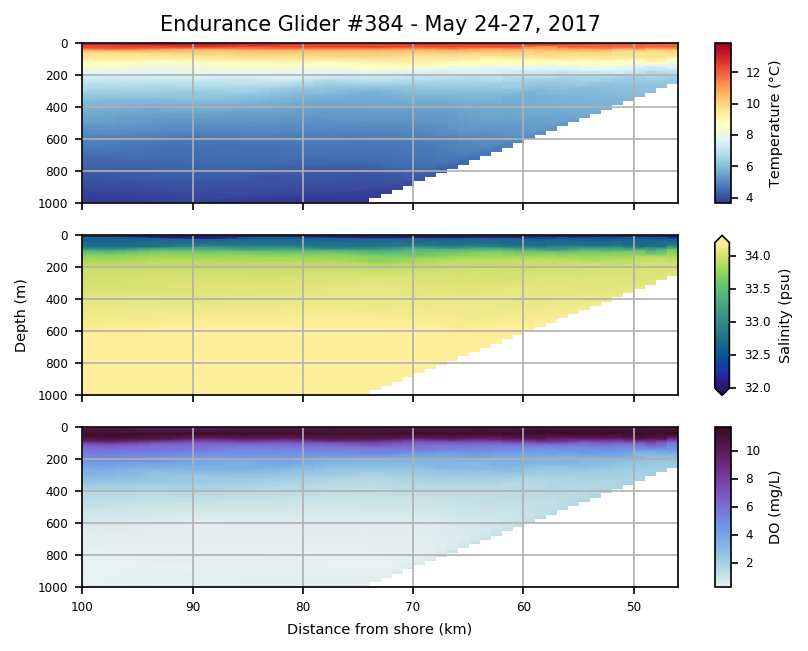

In [23]:
# Plot the data - Distance on x-axis
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True, sharey=True)
fig.set_size_inches(6.4,4.8)
fig.set_dpi(150)

a1 = ax1.pcolor(X,Y,Ztemp, cmap='RdYlBu_r')
a2 = ax2.pcolor(X,Y,Zsal, cmap=cmocean.cm.haline, vmin=32, vmax=34.2)
a3 = ax3.pcolor(X,Y,Zdo, cmap=cmocean.cm.dense)

ax1.grid(); ax2.grid(); ax3.grid();

# ax1.scatter(data_gl384.distance,data_gl384.int_ctd_pressure, s=.5, c='grey')
# ax2.scatter(data_gl384.distance,data_gl384.int_ctd_pressure, s=1, c='grey')
# ax3.scatter(data_gl384.distance,data_gl384.int_ctd_pressure, s=1, c='grey')

cb1 = plt.colorbar(a1,ax=ax1, aspect=10)
cb2 = plt.colorbar(a2,ax=ax2,extend='both', aspect=10)
cb3 = plt.colorbar(a3,ax=ax3, aspect=10)

cb1.set_label('Temperature (°C)',fontsize='x-small')
cb2.set_label('Salinity (psu)',fontsize='x-small')
cb3.set_label('DO (mg/L)',fontsize='x-small')

# ax3.set_xlabel('Distance from CE01ISSM (in km)',fontsize='x-small')
ax3.set_xlabel('Distance from shore (km)',fontsize='x-small')
ax2.set_ylabel("Depth (m)",fontsize='x-small')
ax1.set_title('Endurance Glider #384 - May 24-27, 2017', fontsize='medium')

# ax1.set_xlim(min(data_gl384.distance),max(data_gl384.distance));
ax1.set_xlim(100,46)
# ax1.invert_xaxis()
ax1.set_ylim(1000,0)

ax1.tick_params(labelsize='xx-small')
ax2.tick_params(labelsize='xx-small')
ax3.tick_params(labelsize='xx-small')
cb1.ax.tick_params(labelsize='xx-small')
cb2.ax.tick_params(labelsize='xx-small')
cb3.ax.tick_params(labelsize='xx-small')

plt.savefig("glider384_transect2.png")

In [24]:
# # Reset matplotlib defaults
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

In [25]:
# # sns.set_theme('notebook',style='ticks')
# fig, (ax1) = plt.subplots(1, sharex=True, sharey=True)

# ax1.pcolor(X,Y,Ztemp, cmap='RdYlBu_r')
# ax1.set_xlim(0,200)
# ax1.grid()

# plt.grid()

### Transect Map

In [26]:
# Map stuff
# !apt-get -V -y -qq install python-cartopy python3-cartopy
# !pip uninstall shapely -y
# !pip install shapely --no-binary shapely
# !pip install cartopy --force

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

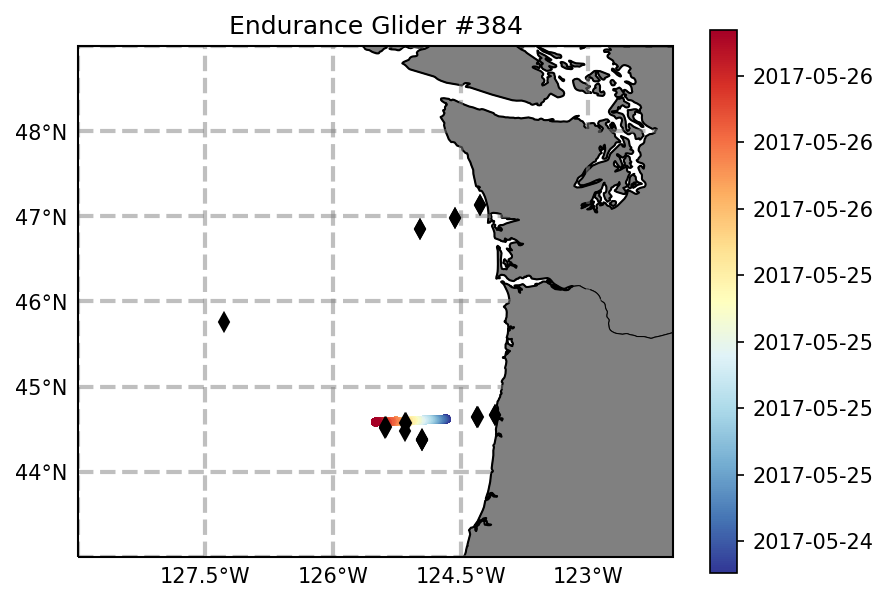

In [27]:
# Glider Deployment Map
fig = plt.figure(figsize=(6.4,4.8),dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-129,-122,43,49], crs=ccrs.PlateCarree())

# Basemaps
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=.5, edgecolor="black",facecolor='grey')
ax.coastlines('10m', linewidth=1)

# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.MaxNLocator(6)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Glider Data
plt.scatter(data_gl384.lon,data_gl384.lat,c=data_gl384.index,marker='.',cmap='RdYlBu_r',transform=ccrs.Geodetic());
cbar = plt.colorbar()
# Fix the colorbar ticks
cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%Y-%m-%d'));

# Add the OOI Sites
sites = pd.read_csv('https://github.com/seagrinch/data-team-python/raw/master/infrastructure/sites.csv')
plt.plot(sites.longitude,sites.latitude,'kd',markersize=6)

plt.title('Endurance Glider #384');

plt.savefig("glider384_map.png")